## Libraries

In [ ]:
import os

import pandas as pd
import numpy as np

from math import sqrt, log, exp

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score

## Data transformations

### Tech Analysis Indicators

In [ ]:
def C(k, df):
    """ Close price in the k-th day """
    assert k >= 0
    return df.loc[k].close


def delta(k, df):
    """ Difference between Open and Close prices in the k-th day """
    assert k >= 0
    return df.loc[k].close - df.loc[k].open


def L(k, N, df):
    """ The Lowest close price in the last N days for the k-th day """
    return min([C(k - i, df) for i in range(N)])


def H(k, N, df):
    """ The Highest close price in the last N days for the k-th day """
    return max([C(k - i, df) for i in range(N)])


def EMA(k, N, df, type_function=C, coef=0.1):
    """ Exponential Moving Average """
    res = 0
    delim = 0

    for i in range(N):

        pr_change = type_function(k - i, df)

        res += pr_change * coef ** i
        delim += coef ** i

    return res / delim


def SMA(k, N, df):
    """ Simple Moving Average """
    return EMA(k, N, df, coef=1)


def ROC(k, N, df):
    """ Rate Of Change """
    return C(k, df) / C(k - N, df)


def RSI(k, N, df):
    """ Relative Strength Index """

    def u(k, df):
        val = delta(k, df)
        return abs(val) * int(val > 0)


    def d(k, df):
        val = delta(k, df)
        return abs(val) * int(val < 0)


    RS = EMA(k, N, df, type_function=u) / EMA(k, N, df, type_function=d)
    return 100 - (100 / (1 + RS))


def stochastic_osc(k, d, df):
    """ Stochastic Oscillator """
    return 100 * (C(k, df) - L(k, 14, df)) / (H(k, 14, df) - L(k, 14, df))


def MACD(k, df):
    """ Moving Average Convergence/Divergence """
    return EMA(k, 12, df) - EMA(k, 26, df)


def SL(k, df):
    """ Signal Line """
    return EMA(k, 9, df, MACD)


def AD(k, df):
    """ Accumulation/Distribution """
    assert k >= 0
    return (df.loc[k].volume
            * (C(k, df) - df.loc[k].low - (df.loc[k].high - C(k, df)))
            / (df.loc[k].high - df.loc[k].low))


def BOS(k, N, df):
    """ Bollinger Oscillator """
    sd = np.std([C(k - i, df) for i in range(N)])
    return (C(k, df) - SMA(k, N, df)) / sd


def DPO(k, N, df):
    """ Detrend Price Oscillator """
    return C(k, df) - SMA(k, N // 2 + 1, df)


def BoBa_UL(k, N, df):
    """ Bollinger Bands - Upper Line """
    return SMA(k, N, df) + 2 * sqrt(sum([(C(k - i, df) - SMA(k - i, N, df)) ** 2 for i in range(N)]) / N)


def BoBa_DL(k, N, df):
    """ Bollinger Bands - Down Line """
    return SMA(k, N, df) - 2 * sqrt(sum([(C(k - i, df) - SMA(k - i, N, df)) ** 2 for i in range(N)]) / N)


def Don_indicator(k, df):
    """ Donchian channel indicator """
    if C(k, df) > H(k - 1, 10, df):
        return 1
    if C(k, df) < L(k - 1, 20, df):
        return -1
    return 0


def last_close(k, N, df):
    """ Close price of (k-N)-th day for the k-th day """
    return C(k - N, df)

### Tech Analysis Theories

#### Fisher Transormation

In [ ]:
def FT(RSI_value):
    """ Fisher Transormation for RSI """
    value = (RSI_value - 50) / 10
    return 50 * ((np.exp(2 * value) - 1) / (np.exp(2 * value) + 1) + 1)
    # return 0.5 * np.log(1 + value / (1 - value))
    # return 50 * (0.5 * np.log(1 + value / (1 - value)) + 1)

#### Ichimoku Number Theory

In [ ]:
def SL_ich(k, df):
    """ Signal Line for Ichimoku Theory """
    return (H(k, 20, df) + L(k, 20, df)) / 2


def TL(k, df):
    """ Return Line """
    return (H(k, 10, df) + L(k, 10, df)) / 2


def S(k, df):
    """ First Line of the range """
    return (SL_ich(k, df) + TL(k, df)) / 2


def SS(k, df):
    """ Second Line of the range """
    return TL(k-10, df)


def DT(k, df):
    """ Chikou Line (Delayed Line) """
    return C(k - 21, df)

In [ ]:
def Ichimoku(k, df):
    """ Ichimoku Number Theory """
    current_close = C(k, df)
    signals = [0, 0, 0]

    if (TL(k - 1, df) < SL_ich(k - 1, df)) and (TL(k, df) > SL_ich(k, df)):
        signals[0] += 1

    if DT(k, df) > current_close:
        signals[1] += 1

    if current_close > max(S(k, df), SS(k, df)):
        signals[2] += 1

    return int(sum(signals) >= 2)

#### Fractal Analysis

In [ ]:
def D(k, T, df):
    """ Fractal Dimension Calculation """

    hT = H(k, T, df)
    hTT = H(k - T, T, df)
    h = H(k, 2 * T, df)

    lT = L(k, T, df)
    lTT = L(k - T, T, df)
    l = L(k, 2 * T, df)

    NT = (hT - lT) / T
    NTT = (hTT - lTT) / T
    N = (h - l) / (2 * T)

    return (log(NT + NTT) - log(N)) / log(2)

In [ ]:
def FRAMA(k, T, df):
    """ Fractal Moving Average """
    return EMA(k, 21, df, coef=exp((D(k, T, df) - 1) * (-4.6)))

### Usage of Data transformations


In [ ]:
def transform(df_):

    df = df_.copy()
    offset = 40
    close = [C(k, df) for k in range(df.shape[0])]

    FRAMA_10_values = [0] * (offset - 1) + [FRAMA(k, 10, df) for k in range(offset - 1, df.shape[0])]
    FRAMA_19_values = [0] * (offset - 1) + [FRAMA(k, 19, df) for k in range(offset - 1, df.shape[0])]
    df['FRAMA_10'] = FRAMA_10_values
    df['FRAMA_19'] = FRAMA_19_values

    df['FRAMA_FRAMA_indicator'] = [0] * offset + [
       int(
           (FRAMA_10_values[k] > FRAMA_19_values[k]) and (FRAMA_10_values[k-1] < FRAMA_19_values[k-1])
           ) for k in range(offset, df.shape[0])
    ]
    df['FRAMA_10_CLOSE_indicator'] = [0] * offset + [
       int(
        (close[k-1] < FRAMA_10_values[k-1]) and (close[k] > FRAMA_10_values[k])
        ) for k in range(offset, df.shape[0])
    ]
    df['FRAMA_19_CLOSE_indicator'] = [0] * offset + [
       int(
        (close[k-1] < FRAMA_19_values[k-1]) and (close[k] > FRAMA_19_values[k])
        ) for k in range(offset, df.shape[0])
    ]

    df['Ichimoku_indicator'] = [0] * offset + [Ichimoku(k, df) for k in range(offset, df.shape[0])]

    df['L_14'] = [0] * offset + [L(k, 14, df) for k in range(offset, df.shape[0])]
    df['L_30'] = [0] * offset + [L(k, 30, df) for k in range(offset, df.shape[0])]

    df['H_14'] = [0] * offset + [H(k, 14, df) for k in range(offset, df.shape[0])]
    df['H_30'] = [0] * offset + [H(k, 30, df) for k in range(offset, df.shape[0])]

    df['EMA_5'] = [0] * offset + [EMA(k, 5, df) for k in range(offset, df.shape[0])]
    df['EMA_10'] = [0] * offset + [EMA(k, 10, df) for k in range(offset, df.shape[0])]
    df['EMA_20'] = [0] * offset + [EMA(k, 20, df) for k in range(offset, df.shape[0])]

    df['SMA_5'] = [0] * offset + [SMA(k, 5, df) for k in range(offset, df.shape[0])]
    df['SMA_10'] = [0] * offset + [SMA(k, 10, df) for k in range(offset, df.shape[0])]
    df['SMA_20'] = [0] * offset + [SMA(k, 20, df) for k in range(offset, df.shape[0])]

    ROC_5_values = [0] * (offset - 1) + [ROC(k, 5, df) for k in range(offset - 1, df.shape[0])]
    ROC_10_values = [0] * (offset - 1) + [ROC(k, 10, df) for k in range(offset - 1, df.shape[0])]
    ROC_20_values = [0] * (offset - 1) + [ROC(k, 20, df) for k in range(offset - 1, df.shape[0])]
    df['ROC_5'] = ROC_5_values
    df['ROC_10'] = ROC_10_values
    df['ROC_20'] = ROC_20_values

    df['ROC_5_indicator'] = [0] * offset + [
        int(
            (ROC_5_values[k-1] < 0) and (ROC_5_values[k] > 0)
        ) for k in range(offset, df.shape[0])
    ]
    df['ROC_10_indicator'] = [0] * offset + [
        int(
            (ROC_10_values[k-1] < 0) and (ROC_10_values[k] > 0)
        ) for k in range(offset, df.shape[0])
    ]
    df['ROC_20_indicator'] = [0] * offset + [
        int(
            (ROC_20_values[k-1] < 0) and (ROC_20_values[k] > 0)
        ) for k in range(offset, df.shape[0])
    ]


    df['RSI_10'] = [0] * offset + [RSI(k, 10, df) for k in range(offset, df.shape[0])]
    df['RSI_20'] = [0] * offset + [RSI(k, 20, df) for k in range(offset, df.shape[0])]

    df['stochastic_osc_5'] = [0] * offset + [stochastic_osc(k, 5, df) for k in range(offset, df.shape[0])]
    df['stochastic_osc_10'] = [0] * offset + [stochastic_osc(k, 10, df) for k in range(offset, df.shape[0])]
    df['stochastic_osc_20'] = [0] * offset + [stochastic_osc(k, 20, df) for k in range(offset, df.shape[0])]

    df['BOS_5'] = [0] * offset + [BOS(k, 5, df) for k in range(offset, df.shape[0])]
    df['BOS_10'] = [0] * offset + [BOS(k, 10, df) for k in range(offset, df.shape[0])]
    df['BOS_20'] = [0] * offset + [BOS(k, 20, df) for k in range(offset, df.shape[0])]

    df['DPO_5'] = [0] * offset + [DPO(k, 5, df) for k in range(offset, df.shape[0])]
    df['DPO_10'] = [0] * offset + [DPO(k, 10, df) for k in range(offset, df.shape[0])]
    df['DPO_20'] = [0] * offset + [DPO(k, 20, df) for k in range(offset, df.shape[0])]

    MACD_values = [0] * (offset - 1) + [MACD(k, df) for k in range(offset - 1, df.shape[0])]
    SL_values = [0] * (offset - 1) + [SL(k, df) for k in range(offset - 1, df.shape[0])]
    df['MACD'] = MACD_values
    df['SL'] = SL_values

    df['MACD_SL_indicator'] = [0] * offset + [
        int(
            (MACD_values[k-1] < SL_values[k-1]) and (MACD_values[k] > SL_values[k])
        ) for k in range(offset, df.shape[0])
    ]

    AD_values = [0] * (offset - 1) + [AD(k, df) for k in range(offset - 1, df.shape[0])]
    df['AD'] = AD_values
    df['AD_indicator'] = [0] * offset + [
        int(
            (close[k-1] < close[k]) and (AD_values[k-1] < AD_values[k])
        ) for k in range(offset, df.shape[0])
    ]

    df['BoBa_UL'] = [0] * offset + [BoBa_UL(k, 20, df) for k in range(offset, df.shape[0])]
    df['BoBa_DL'] = [0] * offset + [BoBa_DL(k, 20, df) for k in range(offset, df.shape[0])]
    df['Don_indicator'] = [0] * offset + [Don_indicator(k, df) for k in range(offset, df.shape[0])]

    df['last_close_1'] = [0] * offset + [last_close(k, 1, df) for k in range(offset, df.shape[0])]
    df['last_close_2'] = [0] * offset + [last_close(k, 2, df) for k in range(offset, df.shape[0])]
    df['last_close_3'] = [0] * offset + [last_close(k, 3, df) for k in range(offset, df.shape[0])]
    df['last_close_4'] = [0] * offset + [last_close(k, 4, df) for k in range(offset, df.shape[0])]
    df['last_close_5'] = [0] * offset + [last_close(k, 5, df) for k in range(offset, df.shape[0])]

    df['next_close'] = [0] * offset + [C(k + 1, df) for k in range(offset, df.shape[0] - 1)] + [0]

    df = df[offset:-1]

    df['fisher_tr_10'] = FT(df.loc[:, 'RSI_10'].values)
    df['fisher_tr_20'] = FT(df.loc[:, 'RSI_20'].values)

    df['RSI_10_indicator'] = (df.loc[:, 'RSI_10'] >= 80).astype(int)
    df['RSI_20_indicator'] = (df.loc[:, 'RSI_20'] >= 80).astype(int)

    df["fisher_10_indicator"] = (df['fisher_tr_10'] >= 80).astype(int)
    df["fisher_20_indicator"] = (df['fisher_tr_20'] >= 80).astype(int)

    df["BoBa_indicator"] = (df['BoBa_DL'] > df['close']).astype(int)
    df["DPO_5_indicator"] = (df['DPO_5'] > 0).astype(int)
    df["DPO_10_indicator"] = (df['DPO_10'] > 0).astype(int)
    df["DPO_20_indicator"] = (df['DPO_20'] > 0).astype(int)

    df["BOS_5_indicator"] = (df['BOS_5'] < -2).astype(int)
    df["BOS_10_indicator"] = (df['BOS_10'] < -2).astype(int)
    df["BOS_20_indicator"] = (df['BOS_20'] < -2).astype(int)

    df["stochastic_osc_5_indicator"] = (df['stochastic_osc_5'] < 30).astype(int)
    df["stochastic_osc_10_indicator"] = (df['stochastic_osc_10'] < 30).astype(int)
    df["stochastic_osc_20_indicator"] = (df['stochastic_osc_20'] < 30).astype(int)

    df.index -= 40

    return df

In [ ]:
df_list = []

for f in  os.listdir('data/prices/'):
    df = pd.read_csv('data/prices/' + f)
    df_new = transform(df).assign(name=f.split('_')[0])
    df_list.append(df_new)
    print(f, "checked")

SBER_day_3years.csv checked
LKOH_day_3years.csv checked
TCSG_day_3years.csv checked
GAZP_day_3years.csv checked
YDEX_day_3years.csv checked
FIVE_day_3years.csv checked
VTBR_day_3years.csv checked
OZON_day_3years.csv checked
AFLT_day_3years.csv checked
MOEX_day_3years.csv checked
MGNT_day_3years.csv checked
IRKT_day_3years.csv checked
RUAL_day_3years.csv checked
ALRS_day_3years.csv checked
MTSS_day_3years.csv checked
CBOM_day_3years.csv checked
SVCB_day_3years.csv checked
RTKM_day_3years.csv checked


<ipython-input-3-365a4862f508>:65: RuntimeWarning: divide by zero encountered in scalar divide
  RS = EMA(k, N, df, type_function=u) / EMA(k, N, df, type_function=d)
<ipython-input-3-365a4862f508>:91: RuntimeWarning: invalid value encountered in scalar divide
  return (df.loc[k].volume


ROSB_day_3years.csv checked


<ipython-input-12-88460b2ea81b>:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fisher_tr_10'] = FT(df.loc[:, 'RSI_10'].values)


BSPB_day_3years.csv checked
VKCO_day_3years.csv checked


In [ ]:
df_big = pd.concat(df_list, ignore_index=True)
print(df_big.shape)
(df_big.head(2))

(13938, 70)


,date,open,close,low,high,volume,FRAMA_10,FRAMA_19,FRAMA_FRAMA_indicator,FRAMA_10_CLOSE_indicator,...,DPO_5_indicator,DPO_10_indicator,DPO_20_indicator,BOS_5_indicator,BOS_10_indicator,BOS_20_indicator,stochastic_osc_5_indicator,stochastic_osc_10_indicator,stochastic_osc_20_indicator,name
0,2021-11-30,311.0,315.0,310.90,318.58,9819147,321.884448,314.674519,0,0,...,1,0,0,0,0,0,1,1,1,SBER
1,2021-12-01,321.3,324.4,319.51,329.44,6993002,348.367991,319.354366,0,0,...,1,1,1,0,0,0,0,0,0,SBER


In [ ]:
b = df_big[df_big.isnull().any(axis=1)]
cols = b.columns[b.isnull().any(axis=0)]
b[cols]

,AD
11962,NaN
12015,NaN
12018,NaN


In [ ]:
df_big = df_big.drop([11962, 12015, 12018])

In [ ]:
df_big.to_csv("data/big_data.csv", index=False)

### Data Analyze

In [ ]:
df_big = pd.read_csv("data/big_data.csv")

df_big.loc[:, 'date'] = pd.to_datetime(df_big.loc[:, 'date'])
df_big = df_big.sort_values('date')

df_big.head(5)

,date,open,close,low,high,volume,FRAMA_10,FRAMA_19,FRAMA_FRAMA_indicator,FRAMA_10_CLOSE_indicator,...,DPO_5_indicator,DPO_10_indicator,DPO_20_indicator,BOS_5_indicator,BOS_10_indicator,BOS_20_indicator,stochastic_osc_5_indicator,stochastic_osc_10_indicator,stochastic_osc_20_indicator,name
0,2021-11-30 00:00:00,311.00,315.000,310.90,318.58,9819147,321.884448,314.674519,0,0,...,1,0,0,0,0,0,1,1,1,SBER
8922,2021-11-30 00:00:00,123.70,128.440,122.55,129.49,5949810,128.073129,128.032297,0,0,...,1,1,1,0,0,0,0,0,0,ALRS
1402,2021-11-30 00:00:00,6741.00,7114.000,6529.00,7245.00,976660,7102.880608,7096.044027,0,1,...,1,1,1,0,0,0,0,0,0,TCSG
8221,2021-11-30 00:00:00,70.95,67.805,66.90,71.99,34141377,67.892897,68.829696,0,0,...,0,0,0,0,0,0,1,1,1,RUAL
11887,2021-11-30 00:00:00,77.40,77.400,77.40,77.80,13,79.553721,77.383319,0,0,...,1,0,0,0,0,0,1,1,1,ROSB


In [ ]:
df_big["Don_indicator"] = df_big["Don_indicator"] * (df_big["Don_indicator"] > 0).astype(int)

In [ ]:
print("All features")
df_big.columns

All features


Index(['date', 'open', 'close', 'low', 'high', 'volume', 'FRAMA_10',
       'FRAMA_19', 'FRAMA_FRAMA_indicator', 'FRAMA_10_CLOSE_indicator',
       'FRAMA_19_CLOSE_indicator', 'Ichimoku_indicator', 'L_14', 'L_30',
       'H_14', 'H_30', 'EMA_5', 'EMA_10', 'EMA_20', 'SMA_5', 'SMA_10',
       'SMA_20', 'ROC_5', 'ROC_10', 'ROC_20', 'ROC_5_indicator',
       'ROC_10_indicator', 'ROC_20_indicator', 'RSI_10', 'RSI_20',
       'stochastic_osc_5', 'stochastic_osc_10', 'stochastic_osc_20', 'BOS_5',
       'BOS_10', 'BOS_20', 'DPO_5', 'DPO_10', 'DPO_20', 'MACD', 'SL',
       'MACD_SL_indicator', 'AD', 'AD_indicator', 'BoBa_UL', 'BoBa_DL',
       'Don_indicator', 'last_close_1', 'last_close_2', 'last_close_3',
       'last_close_4', 'last_close_5', 'next_close', 'fisher_tr_10',
       'fisher_tr_20', 'RSI_10_indicator', 'RSI_20_indicator',
       'fisher_10_indicator', 'fisher_20_indicator', 'BoBa_indicator',
       'DPO_5_indicator', 'DPO_10_indicator', 'DPO_20_indicator',
       'BOS_5_indicato

In [ ]:
binary_indicators = list(filter(lambda x: "indicator" in x, df_big.columns))
print("Num of indicators:", len(binary_indicators))
print("Indicators:")
binary_indicators

Num of indicators: 24
Indicators:


['FRAMA_FRAMA_indicator',
 'FRAMA_10_CLOSE_indicator',
 'FRAMA_19_CLOSE_indicator',
 'Ichimoku_indicator',
 'ROC_5_indicator',
 'ROC_10_indicator',
 'ROC_20_indicator',
 'MACD_SL_indicator',
 'AD_indicator',
 'Don_indicator',
 'RSI_10_indicator',
 'RSI_20_indicator',
 'fisher_10_indicator',
 'fisher_20_indicator',
 'BoBa_indicator',
 'DPO_5_indicator',
 'DPO_10_indicator',
 'DPO_20_indicator',
 'BOS_5_indicator',
 'BOS_10_indicator',
 'BOS_20_indicator',
 'stochastic_osc_5_indicator',
 'stochastic_osc_10_indicator',
 'stochastic_osc_20_indicator']

In [ ]:
# class labels
df_big_a = df_big.copy()
df_big_a['growth'] = (df_big_a['next_close'] > df_big_a['close']).astype(int)

Common Indicators Informativity

In [ ]:
for ind in binary_indicators:
    TP = df_big_a[(df_big_a['growth'] == 1) & (df_big_a[ind] == 1)].shape[0]

    if TP > 0:
        PR = precision_score(df_big_a['growth'], df_big_a[ind])
        RC = recall_score(df_big_a['growth'], df_big_a[ind])
        ACC = accuracy_score(df_big_a['growth'], df_big_a[ind])

        print(f"{ind.rjust(30)}: \t Precision = {PR:.4f},\t Recall = {RC:.4f},\t Accuracy = {ACC:.4f}")
    else:
        print(f"{ind.rjust(30)}: trivial")

         FRAMA_FRAMA_indicator: 	 Precision = 0.4819,	 Recall = 0.1810,	 Accuracy = 0.5174
      FRAMA_10_CLOSE_indicator: 	 Precision = 0.4818,	 Recall = 0.1959,	 Accuracy = 0.5168
      FRAMA_19_CLOSE_indicator: 	 Precision = 0.4715,	 Recall = 0.1971,	 Accuracy = 0.5125
            Ichimoku_indicator: 	 Precision = 0.4451,	 Recall = 0.1075,	 Accuracy = 0.5112
               ROC_5_indicator: trivial
              ROC_10_indicator: trivial
              ROC_20_indicator: trivial
             MACD_SL_indicator: 	 Precision = 0.4661,	 Recall = 0.2184,	 Accuracy = 0.5087
                  AD_indicator: 	 Precision = 0.4679,	 Recall = 0.3403,	 Accuracy = 0.5016
                 Don_indicator: 	 Precision = 0.4330,	 Recall = 0.1393,	 Accuracy = 0.5033
              RSI_10_indicator: 	 Precision = 0.4517,	 Recall = 0.3629,	 Accuracy = 0.4869
              RSI_20_indicator: 	 Precision = 0.4517,	 Recall = 0.3629,	 Accuracy = 0.4869
           fisher_10_indicator: 	 Precision = 0.4576,	 Recall

In [ ]:
print("Индикаторы с 1 значением на все входы:")
for col in df_big_a.columns:
    if len(df_big_a[col].unique()) == 1:
        print(col)

Индикаторы с 1 значением на все входы:
ROC_5_indicator
ROC_10_indicator
ROC_20_indicator
BOS_5_indicator


In [ ]:
binary_indicators = pd.Index(binary_indicators).difference(["ROC_5_indicator", "ROC_10_indicator", "ROC_20_indicator", "BOS_5_indicator"]).tolist()
print("Нетривиальные индикаторы:")
print(len(binary_indicators))
binary_indicators

Нетривиальные индикаторы:
20


['AD_indicator',
 'BOS_10_indicator',
 'BOS_20_indicator',
 'BoBa_indicator',
 'DPO_10_indicator',
 'DPO_20_indicator',
 'DPO_5_indicator',
 'Don_indicator',
 'FRAMA_10_CLOSE_indicator',
 'FRAMA_19_CLOSE_indicator',
 'FRAMA_FRAMA_indicator',
 'Ichimoku_indicator',
 'MACD_SL_indicator',
 'RSI_10_indicator',
 'RSI_20_indicator',
 'fisher_10_indicator',
 'fisher_20_indicator',
 'stochastic_osc_10_indicator',
 'stochastic_osc_20_indicator',
 'stochastic_osc_5_indicator']

Indicators Informativity per each Company

In [ ]:
for comp in df_big_a['name'].unique():
    temp_df = df_big_a[df_big_a['name'] == comp]

    print(comp)

    neg = temp_df[temp_df['growth'] == 0].shape[0]
    pos = temp_df[temp_df['growth'] == 1].shape[0]
    print(f"Disbalance: {neg} negatives, {pos} positives")

    for ind in binary_indicators:
        TP = temp_df[(temp_df['growth'] == 1) & (temp_df[ind] == 1)].shape[0]

        if TP > 0:
            PR = precision_score(df_big_a['growth'], df_big_a[ind])
            RC = recall_score(df_big_a['growth'], df_big_a[ind])
            ACC = accuracy_score(df_big_a['growth'], df_big_a[ind])

            print(f"{ind.rjust(30)}: \t Precision = {PR:.4f},\t Recall = {RC:.4f},\t Accuracy = {ACC:.4f}")
    print()

SBER
Disbalance: 327 negatives, 374 positives
                  AD_indicator: 	 Precision = 0.4679,	 Recall = 0.3403,	 Accuracy = 0.5016
              BOS_10_indicator: 	 Precision = 0.5215,	 Recall = 0.0511,	 Accuracy = 0.5259
              BOS_20_indicator: 	 Precision = 0.5213,	 Recall = 0.0663,	 Accuracy = 0.5264
                BoBa_indicator: 	 Precision = 0.5442,	 Recall = 0.0362,	 Accuracy = 0.5267
              DPO_10_indicator: 	 Precision = 0.4707,	 Recall = 0.4989,	 Accuracy = 0.4943
              DPO_20_indicator: 	 Precision = 0.4695,	 Recall = 0.5031,	 Accuracy = 0.4927
               DPO_5_indicator: 	 Precision = 0.4576,	 Recall = 0.4739,	 Accuracy = 0.4821
                 Don_indicator: 	 Precision = 0.4330,	 Recall = 0.1393,	 Accuracy = 0.5033
      FRAMA_10_CLOSE_indicator: 	 Precision = 0.4818,	 Recall = 0.1959,	 Accuracy = 0.5168
      FRAMA_19_CLOSE_indicator: 	 Precision = 0.4715,	 Recall = 0.1971,	 Accuracy = 0.5125
         FRAMA_FRAMA_indicator: 	 Precision 

### MLP feature (indicator)

In [ ]:
info_features = ['date', 'name', 'growth', 'next_close']                                        # meta information
null_features = ["ROC_5_indicator", "ROC_10_indicator", "ROC_20_indicator", "BOS_5_indicator"]  # 0 for every input
trainable_features = df_big_a.columns.difference(info_features + null_features)                 # can be used for training

print("Количество признаков для обучения:", len(trainable_features))
print("Признаки:")
trainable_features

Количество признаков для обучения: 63
Признаки:


Index(['AD', 'AD_indicator', 'BOS_10', 'BOS_10_indicator', 'BOS_20',
       'BOS_20_indicator', 'BOS_5', 'BoBa_DL', 'BoBa_UL', 'BoBa_indicator',
       'DPO_10', 'DPO_10_indicator', 'DPO_20', 'DPO_20_indicator', 'DPO_5',
       'DPO_5_indicator', 'Don_indicator', 'EMA_10', 'EMA_20', 'EMA_5',
       'FRAMA_10', 'FRAMA_10_CLOSE_indicator', 'FRAMA_19',
       'FRAMA_19_CLOSE_indicator', 'FRAMA_FRAMA_indicator', 'H_14', 'H_30',
       'Ichimoku_indicator', 'L_14', 'L_30', 'MACD', 'MACD_SL_indicator',
       'ROC_10', 'ROC_20', 'ROC_5', 'RSI_10', 'RSI_10_indicator', 'RSI_20',
       'RSI_20_indicator', 'SL', 'SMA_10', 'SMA_20', 'SMA_5', 'close',
       'fisher_10_indicator', 'fisher_20_indicator', 'fisher_tr_10',
       'fisher_tr_20', 'high', 'last_close_1', 'last_close_2', 'last_close_3',
       'last_close_4', 'last_close_5', 'low', 'open', 'stochastic_osc_10',
       'stochastic_osc_10_indicator', 'stochastic_osc_20',
       'stochastic_osc_20_indicator', 'stochastic_osc_5',
       'sto

In [ ]:
ratio = 0.8

train_df_size = int(df_big_a.shape[0] * ratio)
train_df = df_big_a[:train_df_size]
test_df = df_big_a[train_df_size:]

print("Количество объектов для обучения всей модели (включая трейн и тест MLP):", train_df.shape[0])
print("Количество объектов для теста всей модели:", test_df.shape[0])

Количество объектов для обучения всей модели (включая трейн и тест MLP): 11148
Количество объектов для теста всей модели: 2787


In [ ]:
ratio_mlp = 0.7

train_df_for_mlp_size = int(train_df.shape[0] * ratio_mlp)
train_df_for_mlp = train_df[:train_df_for_mlp_size]
test_df_for_mlp = train_df[train_df_for_mlp_size:]


print("Количество объектов для обучения mlp индикатора:", train_df_for_mlp.shape[0])
print("Количество объектов для теста mlp индикатора:", test_df_for_mlp.shape[0])

Количество объектов для обучения mlp индикатора: 7803
Количество объектов для теста mlp индикатора: 3345


In [ ]:
train_df_for_mlp_norm = train_df_for_mlp.copy()
test_df_for_mlp_norm = test_df_for_mlp.copy()

for col in trainable_features.difference(binary_indicators):
    train_df_for_mlp_norm[col] = 0.8 * train_df_for_mlp_norm[col] / train_df_for_mlp_norm[col].max() + 0.1
    test_df_for_mlp_norm[col] = 0.8 * test_df_for_mlp_norm[col] / test_df_for_mlp_norm[col].max() + 0.1

In [ ]:
from itertools import combinations


combinations_of_features_4 = list(combinations(trainable_features.tolist(), 4))
combinations_of_features_5 = list(combinations(trainable_features.tolist(), 5))

print("Количество доступных наборов признаков:")
print(len(combinations_of_features_4) + len(combinations_of_features_5))

Количество доступных наборов признаков:
7624512


In [ ]:
from random import choices, seed

seed(44)
combinations_of_features_sample = choices(combinations_of_features_4, k=32) + choices(combinations_of_features_5, k=32)
result_scores = []
best_model = None

for combination in combinations_of_features_sample:
    n = len(combination)

    shapes = [n + 1, 2 * n + 1, 2 * n - 1, 3 * n]
    activations = ["logistic", "tanh"]

    for shape in shapes:
        for activation in activations:

            model = MLPClassifier(
                (shape),
                activation=activation,
                max_iter=5000,
                random_state=44
            )
            model.fit(train_df_for_mlp_norm[[*combination]].values, train_df_for_mlp['growth'].values)
            score = accuracy_score(test_df_for_mlp['growth'].values, model.predict(test_df_for_mlp_norm[[*combination]].values))

            result_scores.append([combination, shape, activation, score, model])
    print(f"Set of features: {combination} passed. Current Best model: {max(result_scores, key=lambda x: x[3])[:4]}")

print()
print("Best Model:")
print(max(result_scores, key=lambda x: x[3])[:4])
best_model_item = max(result_scores, key=lambda x: x[3])
best_model = best_model_item[4]
best_combination = best_model_item[0]

Set of features: ('BoBa_DL', 'FRAMA_10_CLOSE_indicator', 'Ichimoku_indicator', 'stochastic_osc_20') passed. Current Best model: [('BoBa_DL', 'FRAMA_10_CLOSE_indicator', 'Ichimoku_indicator', 'stochastic_osc_20'), 12, 'logistic', 0.5240657698056801]
Set of features: ('DPO_10', 'RSI_20_indicator', 'last_close_1', 'stochastic_osc_20') passed. Current Best model: [('DPO_10', 'RSI_20_indicator', 'last_close_1', 'stochastic_osc_20'), 7, 'tanh', 0.5285500747384155]
Set of features: ('FRAMA_FRAMA_indicator', 'H_14', 'L_14', 'L_30') passed. Current Best model: [('FRAMA_FRAMA_indicator', 'H_14', 'L_14', 'L_30'), 5, 'logistic', 0.5288490284005979]
Set of features: ('BOS_10', 'RSI_10_indicator', 'SMA_5', 'stochastic_osc_10') passed. Current Best model: [('FRAMA_FRAMA_indicator', 'H_14', 'L_14', 'L_30'), 5, 'logistic', 0.5288490284005979]
Set of features: ('BOS_10_indicator', 'L_14', 'ROC_10', 'volume') passed. Current Best model: [('BOS_10_indicator', 'L_14', 'ROC_10', 'volume'), 9, 'tanh', 0.5324

In [ ]:
test_df_norm = test_df[[*best_combination]].copy()
train_df_norm = train_df[[*best_combination]].copy()

for col in best_combination:
    test_df_norm[col] = 0.8 * test_df_norm[col] / test_df_norm[col].max() + 0.1
    train_df_norm[col] = 0.8 * train_df_norm[col] / train_df_norm[col].max() + 0.1

train_df.loc[:, "mlp_prediction"] = best_model.predict(train_df_norm.values)
test_df.loc[:, "mlp_prediction"] = best_model.predict(test_df_norm.values)

In [ ]:
binary_indicators.append('mlp_prediction')

In [ ]:
train_df.to_csv("data/train.csv")
test_df.to_csv("data/test.csv")

## Hopfield Network

### Data Preparation

In [ ]:
train_df = pd.read_csv("data/train.csv", index_col=0).reset_index()
test_df = pd.read_csv("data/test.csv", index_col=0).reset_index()

In [ ]:
# cmd to get:
# train_df.columns[(train_df.columns.str.contains("indicator") | train_df.columns.str.contains("mlp")) & ~(train_df.columns.str.contains("ROC")) & ~(train_df.columns.str.contains("BOS_5"))].shape
binary_indicators = ['AD_indicator', 'BOS_10_indicator', 'BOS_20_indicator', 'BoBa_indicator', 'DPO_10_indicator', 'DPO_20_indicator', 'DPO_5_indicator', 'Don_indicator', 'FRAMA_10_CLOSE_indicator', 'FRAMA_19_CLOSE_indicator', 'FRAMA_FRAMA_indicator', 'Ichimoku_indicator', 'MACD_SL_indicator', 'RSI_10_indicator', 'RSI_20_indicator', 'fisher_10_indicator', 'fisher_20_indicator', 'stochastic_osc_10_indicator', 'stochastic_osc_20_indicator', 'stochastic_osc_5_indicator', 'mlp_prediction']

In [ ]:
# train
train_df_binary = train_df[binary_indicators + ['next_close', 'close', 'growth']]

positive_samples = train_df.loc[train_df['growth'] == 1, binary_indicators].replace(to_replace=0, value=-1).drop_duplicates(keep="first")
negative_samples = train_df.loc[train_df['growth'] == 0, binary_indicators].replace(to_replace=0, value=-1).drop_duplicates(keep="first")

# test
test_df_binary = test_df[binary_indicators + ['next_close', 'close', 'growth']]
test_samples = test_df.loc[:, binary_indicators].replace(to_replace=0, value=-1).values

In [ ]:
print(positive_samples.shape[0])
print(negative_samples.shape[0])

805
820


In [ ]:
def_positive_samples = []   # only definitely positive
def_negative_samples = []   # only definitely negative

for sample in positive_samples.values.tolist():
    if sample not in negative_samples.values.tolist():
        def_positive_samples.append(sample)

for sample in negative_samples.values.tolist():
    if sample not in positive_samples.values.tolist():
        def_negative_samples.append(sample)

training_samples_positive = np.array(def_positive_samples)
training_samples_negative = np.array(def_negative_samples)
training_samples = np.array(def_positive_samples + def_negative_samples)
training_samples.shape

(577, 21)

In [ ]:
print(training_samples_positive.shape[0])
print(training_samples_negative.shape[0])

281
296


### Model

In [ ]:
class HopfieldNet:

    def __init__(self, max_iter=100):
        self.max_iter = max_iter
        self.w = None
        self.dim = None
        self.images = None

    def fit(self, positive, negative):

        objs = np.concatenate((positive, negative), axis=0)

        self.images = objs.copy().tolist()
        self.positive_images = positive.copy().tolist()
        self.negative_images = negative.copy().tolist()

        self.dim = objs.shape[1]
        self.w = np.sum(
            [x.reshape((-1, 1)) @ x.reshape((1, -1)) for x in objs],
            axis=0
        ) / self.dim
        # np.fill_diagonal(self.w, 0)

        return self.w

    def calculate_new_async(self, old_vector):
        prev = old_vector.copy()
        res = [0 for i in range(self.dim)]

        for i in range(self.dim):
            for j in range(self.dim):
                if i <= j:
                    res[i] += self.w[i, j] * prev[j]
                if i > j:
                    res[i] += self.w[i, j] * res[j]

        return np.sign(res)

    def converge_image(self, x):
        old_x = x.copy()
        new_x = self.calculate_new_async(old_x)

        for _ in range(self.max_iter):
            if (new_x == old_x).all():
                return new_x

            old_x = new_x.copy()
            new_x = self.calculate_new_async(old_x)

        # raise AssertionError(f"No convegency for: \n{x}")
        print("No convegency")
        print(x)
        return new_x

    def predict(self, x):
        assert x.ndim == 1
        assert x.shape[0] == self.dim

        image = self.converge_image(x)
        return int(self.is_in_positive_images(image))

    def predict_negative(self, x):
        assert x.ndim == 1
        assert x.shape[0] == self.dim

        image = self.converge_image(x)
        return int(self.is_in_negative_images(image))

    def predict_for_list(self, list_x):
        return np.array(
            [self.predict(x) for x in list_x]
        )

    def predict_negative_for_list(self, list_x):
        return np.array(
            [self.predict_negative(x) for x in list_x]
        )

    def is_in_positive_images(self, x):
        return (x.reshape((-1)).tolist() in self.positive_images) or ((-1 * x).reshape((-1)).tolist() in self.positive_images)

    def is_in_negative_images(self, x):
        return (x.reshape((-1)).tolist() in self.negative_images) or ((-1 * x).reshape((-1)).tolist() in self.negative_images)

### Train and Test

#### Full set of samples for training

In [ ]:
model_hopf = HopfieldNet()

model_hopf.fit(
    training_samples_positive,
    training_samples_negative
)

ans = model_hopf.predict_for_list(test_samples)

accc = accuracy_score(test_df['growth'], ans)
prec = precision_score(test_df['growth'], ans, zero_division=0.0)
rec = recall_score(test_df['growth'], ans)
accc, prec, rec

(0.5357014711158953, 0.4526143790849673, 0.22411003236245955)

#### Only 4 random samples (2 positive + 2 negative) for training

In [ ]:
def money_statistics(result_for_test, close_prices, next_close_prices):
    true_result = np.sign(next_close_prices - close_prices)
    return (
        (np.abs(close_prices - next_close_prices)) * (true_result == result_for_test).astype(int) * result_for_test -
        (np.abs(close_prices - next_close_prices)) * (true_result != result_for_test).astype(int) * result_for_test
    ).sum()

In [ ]:
def train_and_test_model(k=2):
    model_hopf = HopfieldNet()
    model_hopf.fit(
        training_samples_positive[np.random.choice(np.arange(training_samples_positive.shape[0] - 1), size=k, replace=False), :],
        training_samples_negative[np.random.choice(np.arange(training_samples_negative.shape[0] - 1), size=k, replace=False), :]
    )

    ans = model_hopf.predict_for_list(test_samples)

    accc = accuracy_score(test_df['growth'], ans)
    prec = precision_score(test_df['growth'], ans, zero_division=0.0)
    rec = recall_score(test_df['growth'], ans)
    ms = money_statistics(ans, test_df['close'].values, test_df['next_close'].values)

    return model_hopf, accc, prec, rec, ms

In [ ]:
res = []
for i in range(2000):
    r = train_and_test_model()
    res.append(r)

In [ ]:
ac, pr, rc, mn = max(list(filter(lambda y: y[2] > 0, res)), key=lambda x: x[1])[1:]
print(ac, pr, rc, mn)

0.5572299964119124 0.5034722222222222 0.11731391585760517 935.6370000000002


#### k $\in[1;20]$ random samples for training

In [ ]:
for k in range(1, 21):
    res_k = []
    for i in range(300):
        r = train_and_test_model(k=k)
        res_k.append(r)
    print(k)
    print(max(list(filter(lambda y: y[2] > 0, res_k)), key=lambda x: x[1])[1:])
    print(max(list(filter(lambda y: y[2] > 0, res_k)), key=lambda x: x[2])[1:])
    print(max(list(filter(lambda y: y[2] > 0, res_k)), key=lambda x: x[4])[1:])
    print()

1
(0.5371367061356297, 0.46005917159763315, 0.25161812297734626, np.float64(-1079.9989999999998))
(0.5317545748116254, 0.4697633654688869, 0.4336569579288026, np.float64(-956.6170000000001))
(0.5184786508790814, 0.44325481798715205, 0.33495145631067963, np.float64(2837.201))

2
(0.5626121277359167, 0.5611510791366906, 0.06310679611650485, np.float64(863.9770000000002))
(0.5583064226767133, 0.8571428571428571, 0.0048543689320388345, np.float64(356.435))
(0.5378543236454969, 0.4548611111111111, 0.21197411003236247, np.float64(1308.1660000000002))

3
(0.5629709364908504, 0.6125, 0.03964401294498382, np.float64(252.83500000000024))
(0.5575888051668461, 0.7142857142857143, 0.0040453074433656954, np.float64(16.183000000000035))
(0.5249372084678866, 0.4568627450980392, 0.37702265372168287, np.float64(2829.344000000001))

4
(0.5640473627556513, 0.6842105263157895, 0.03155339805825243, np.float64(799.4690000000003))
(0.5640473627556513, 0.6842105263157895, 0.03155339805825243, np.float64(799.46

In [ ]:
s = [
    (0.5572299964119124, 0.5034722222222222, 0.11731391585760517, 935.6370000000002),
    (0.5626121277359167, 0.5611510791366906, 0.06310679611650485, np.float64(863.9770000000002)),
    (0.5629709364908504, 0.6125, 0.03964401294498382, np.float64(252.83500000000024)),
    (0.5640473627556513, 0.6842105263157895, 0.03155339805825243, np.float64(799.4690000000003)),
    (0.5601004664513815, 0.578125, 0.029935275080906147, np.float64(663.938)),
    (0.5618945102260495, 0.6363636363636364, 0.02831715210355987, np.float64(129.7689999999999)),
    (0.5575888051668461, 0.5137614678899083, 0.045307443365695796, np.float64(324.40999999999997)),
    (0.5629709364908504, 0.5478723404255319, 0.08333333333333333, np.float64(399.631)),
    (0.5597416576964478, 0.5266272189349113, 0.07200647249190939, np.float64(480.26799999999974)),
    (0.5593828489415141, 0.6222222222222222, 0.010517799352750809, np.float64(22.469000000000047)),
    (0.5568711876569788, 0.5333333333333333, 0.006472491909385114, np.float64(222.22999999999988)),
    (0.5568711876569788, 0.5714285714285714, 0.003236245954692557, np.float64(258.97999999999996)),
    (0.5547183351273771, 0.46835443037974683, 0.029935275080906147, np.float64(-535.2019999999999)),
    (0.5565123789020452, 0.5, 0.02831715210355987, np.float64(217.18899999999996)),
    (0.5310369573017582, 0.4492131616595136, 0.02540453074433657, np.float64(-168.8209999999998)),
    (0.5565123789020452, 0.5, 0.0040453074433656954, np.float64(345.81499999999994)),
    (0.5568711876569788, 0.5666666666666666, 0.0016181229773462784, np.float64(361.715)),
    (0.5572299964119124, 0.5119047619047619, 0.03478964401294499, np.float64(200.528)),
    (0.5339074273412271, 0.42953020134228187, 0.01553398058252427, np.float64(-1426.0290000000002)),
    (0.5572299964119124, 0.5119047619047619, 0.03478964401294499, np.float64(82.32799999999995))
]

In [ ]:
res_accuracy = np.array(s)[:, 0]
res_precision = np.array(s)[:, 1]
res_recall = np.array(s)[:, 2]
res_money = np.array(s)[:, 3]

In [ ]:
from sklearn.linear_model import LinearRegression

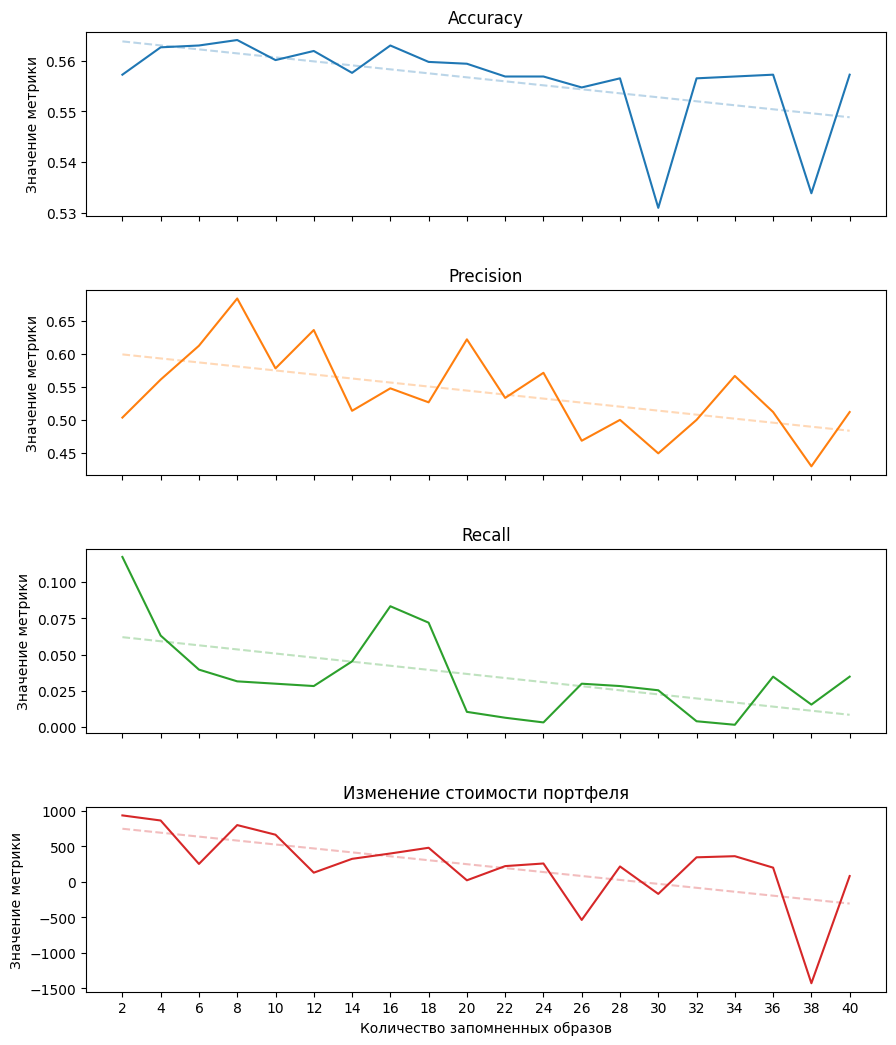

In [ ]:
from matplotlib import pyplot as plt

x = (np.arange(20) + 1).astype(int) * 2

y1 = res_accuracy
m_1 = LinearRegression().fit(x.reshape(-1, 1), y1)
y_val_1 = m_1.predict(x.reshape(-1, 1))

y2 = res_precision
m_2 = LinearRegression().fit(x.reshape(-1, 1), y2)
y_val_2 = m_2.predict(x.reshape(-1, 1))

y3 = res_recall
m_3 = LinearRegression().fit(x.reshape(-1, 1), y3)
y_val_3 = m_3.predict(x.reshape(-1, 1))

y4 = res_money
m_4 = LinearRegression().fit(x.reshape(-1, 1), y4)
y_val_4 = m_4.predict(x.reshape(-1, 1))

fig, axs = plt.subplots(4, 1, figsize=(10, 12))

axs[0].plot(x, y1)
axs[0].plot(x, y_val_1, 'tab:blue', linestyle='--', alpha=0.3)
axs[0].set_title('Accuracy')

axs[1].plot(x, y2, 'tab:orange')
axs[1].plot(x, y_val_2, 'tab:orange', linestyle='--', alpha=0.3)
axs[1].set_title('Precision')

axs[2].plot(x, y3, 'tab:green')
axs[2].plot(x, y_val_3, 'tab:green', linestyle='--', alpha=0.3)
axs[2].set_title('Recall')

axs[3].plot(x, y4, 'tab:red')
axs[3].plot(x, y_val_4, 'tab:red', linestyle='--', alpha=0.3)
axs[3].set_title('Изменение стоимости портфеля')

for ax in axs.flat:
    ax.set(xlabel='Количество запомненных образов', ylabel='Значение метрики')
    ax.set_xticks(x)

for ax in axs.flat:
    ax.label_outer()

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

fig.savefig("hopf_for_k.svg")

#### Test for MLP

In [ ]:
accuracy_score(test_df['growth'], test_df['mlp_prediction']), precision_score(test_df['growth'], test_df['mlp_prediction']), recall_score(test_df['growth'], test_df['mlp_prediction'])

(0.521707929673484, 0.4612310151878497, 0.46682847896440127)

In [ ]:
def print_money_statistics(result_for_test, close_prices, next_close_prices):
    true_result = np.sign(next_close_prices - close_prices)

    delta_rub = (
        (np.abs(close_prices - next_close_prices)) * (true_result == result_for_test).astype(int) * result_for_test -
        (np.abs(close_prices - next_close_prices)) * (true_result != result_for_test).astype(int) * result_for_test
    ).sum()
    delta_pr = delta_rub / (close_prices * result_for_test).sum()

    print("Изменение цены портфеля (проценты):")
    print(delta_pr * 100)

    print("Изменение цены портфеля (рубли):")
    print(delta_rub)

In [ ]:
print("Статистика для ответов полносвязной сети:")
print_money_statistics(test_df['mlp_prediction'], test_df['close'].values, test_df['next_close'].values)

Статистика для ответов полносвязной сети:
Изменение цены портфеля (проценты):
-0.17855404407852832
Изменение цены портфеля (рубли):
-2901.542
